## preparing TA snRNA dataset using Scanpy

In [1]:
import scanpy as sc
import anndata as ad
from scipy import io
from scipy.sparse import coo_matrix, csr_matrix
import numpy as np
import os
import pandas as pd
import sys

In [9]:
# load anndata objects
data_dir = '/ocean/projects/cis240075p/asachan/bio_informatics_analysis/TA_muscle_mouse_analysis/Seurat_analysis_outputs/objects/'
all_samples_path = os.path.join(data_dir, 'major_celltype_seurat.h5ad')
# wt_samples_path = os.path.join(data_dir, 'WT_major_celltype.h5ad')
# ko_samples_path = os.path.join(data_dir, 'KO_major_celltype.h5ad')

In [10]:
adata = ad.read(all_samples_path)
adata

/ocean/projects/cis240075p/asachan/.conda/envs/celloracle/lib/python3.10/site-packages/anndata/__init__.py:55: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 40106 × 20513
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'log10GenesPerUMI', 'seurat_clusters', 'RNA_snn_res.0.6', 'cell_type', 'condition'
    var: 'highly_variable'
    uns: 'harmony', 'pca'
    obsm: 'X_harmony', 'X_pca', 'X_umap'
    varm: 'PCs', 'harmony'
    layers: 'counts'
    obsp: 'nn', 'snn'

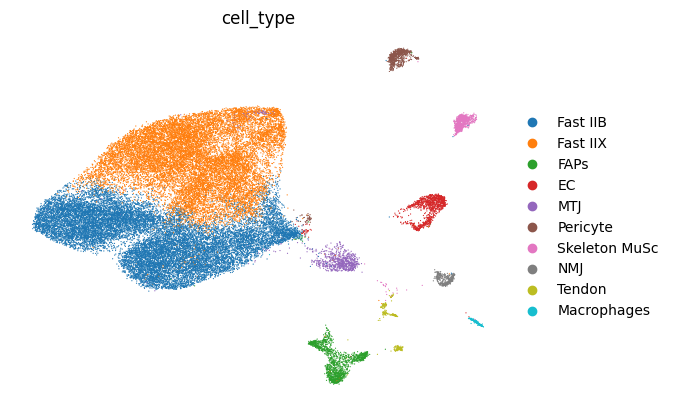

In [11]:
#umap colors by both cell metadata and var.names (gene_names)
sc.pl.umap(adata, color=['cell_type'], frameon=False, save=False)

#### Filter mt- ribosomal and other non variable genes

In [12]:
import logging

adata.var_names = [gene.upper() for gene in adata.var_names]
logging.info('Only consider genes with more than 3 counts')
sc.pp.filter_genes(adata, min_counts=3)
logging.info('Normalize gene expression matrix with total UMI count per cell')
sc.pp.normalize_per_cell(adata, key_n_counts='n_counts_all')
# Filter for mitochondrial, linc, rps and rpl genes
logging.info('Filtering the data for MT, linc, rps and rpl genes')
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
adata.var['linc'] = adata.var_names.str.startswith('LINC') # annotate the group of linc genes as 'linc'
adata.var['rps'] = adata.var_names.str.startswith('RPS') # annotate the group of linc genes as 'rps'
adata.var['rpl'] = adata.var_names.str.startswith('RPL') # annotate the group of linc genes as 'rps
adata.var_names = [gene.upper() for gene in adata.var_names]
adata = adata[:,(~adata.var['mt'] & ~adata.var['linc'] & ~adata.var['rps'] & ~adata.var['rpl'])]

In [13]:
# Select top 3000 highly-variable genes
adata.var_names = [gene.upper() for gene in adata.var_names]
filter_result = sc.pp.filter_genes_dispersion(adata.X,
                                              flavor='cell_ranger',
                                              n_top_genes=3000,
                                              log=False)

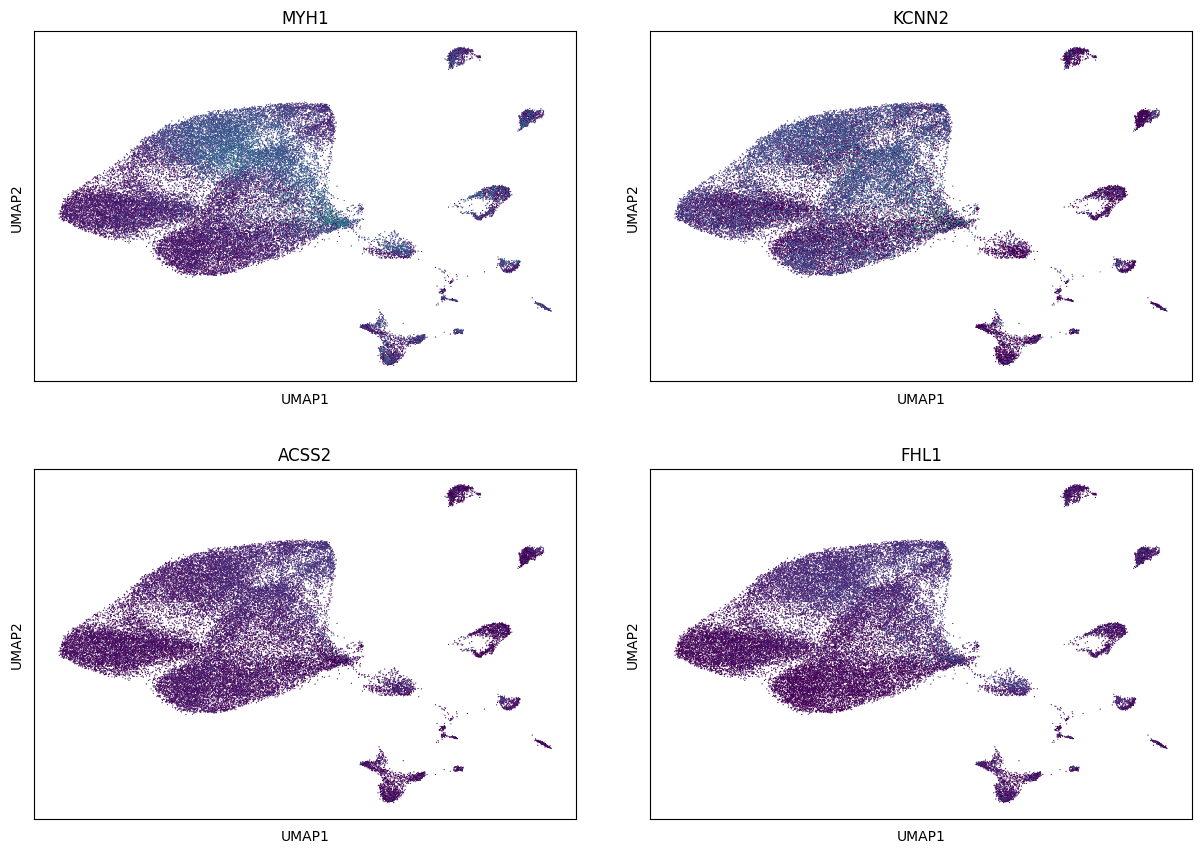

<Figure size 640x480 with 0 Axes>

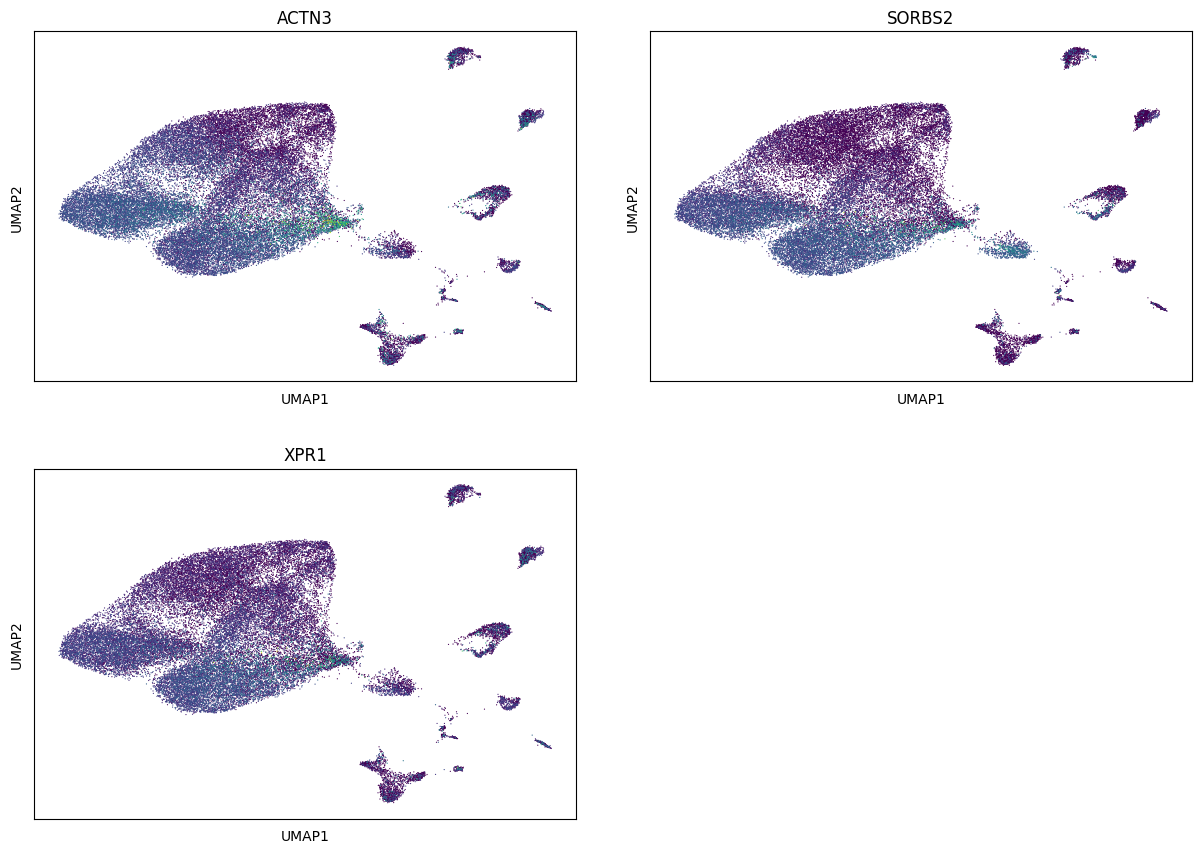

<Figure size 640x480 with 0 Axes>

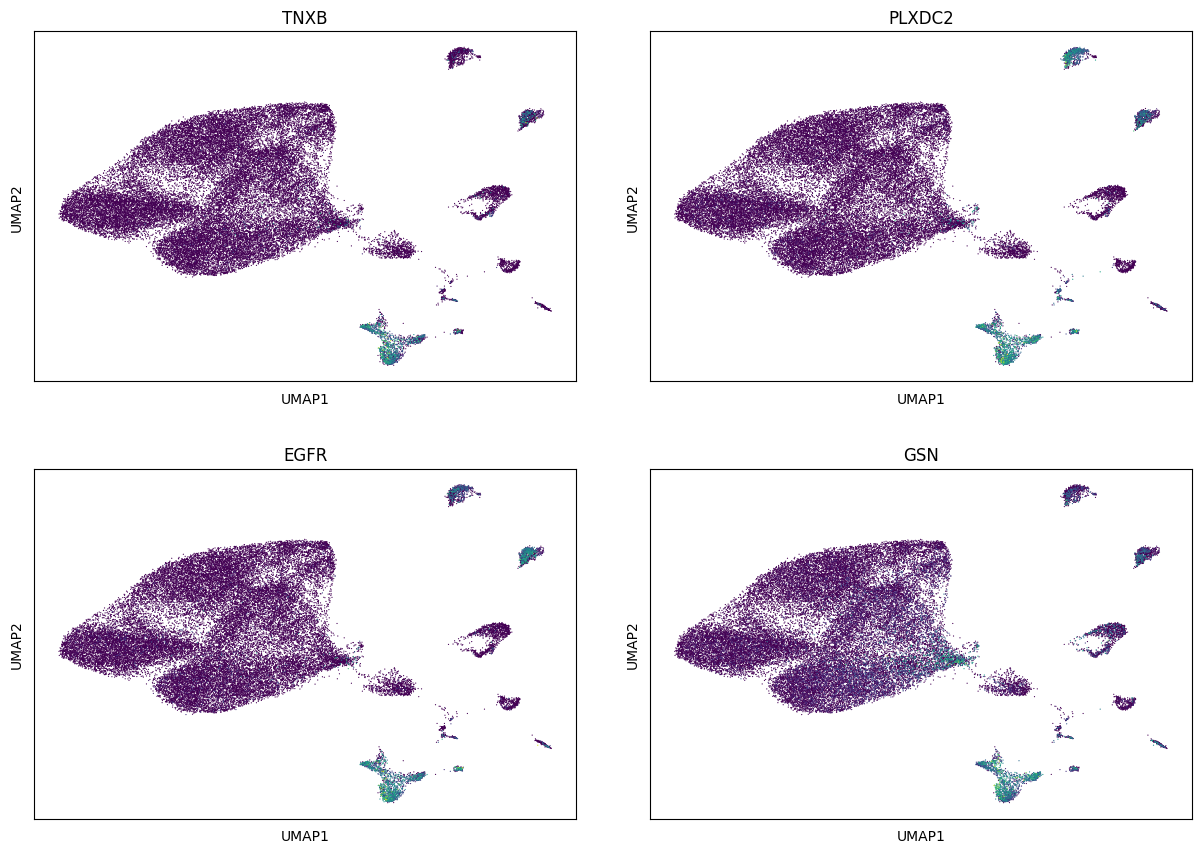

<Figure size 640x480 with 0 Axes>

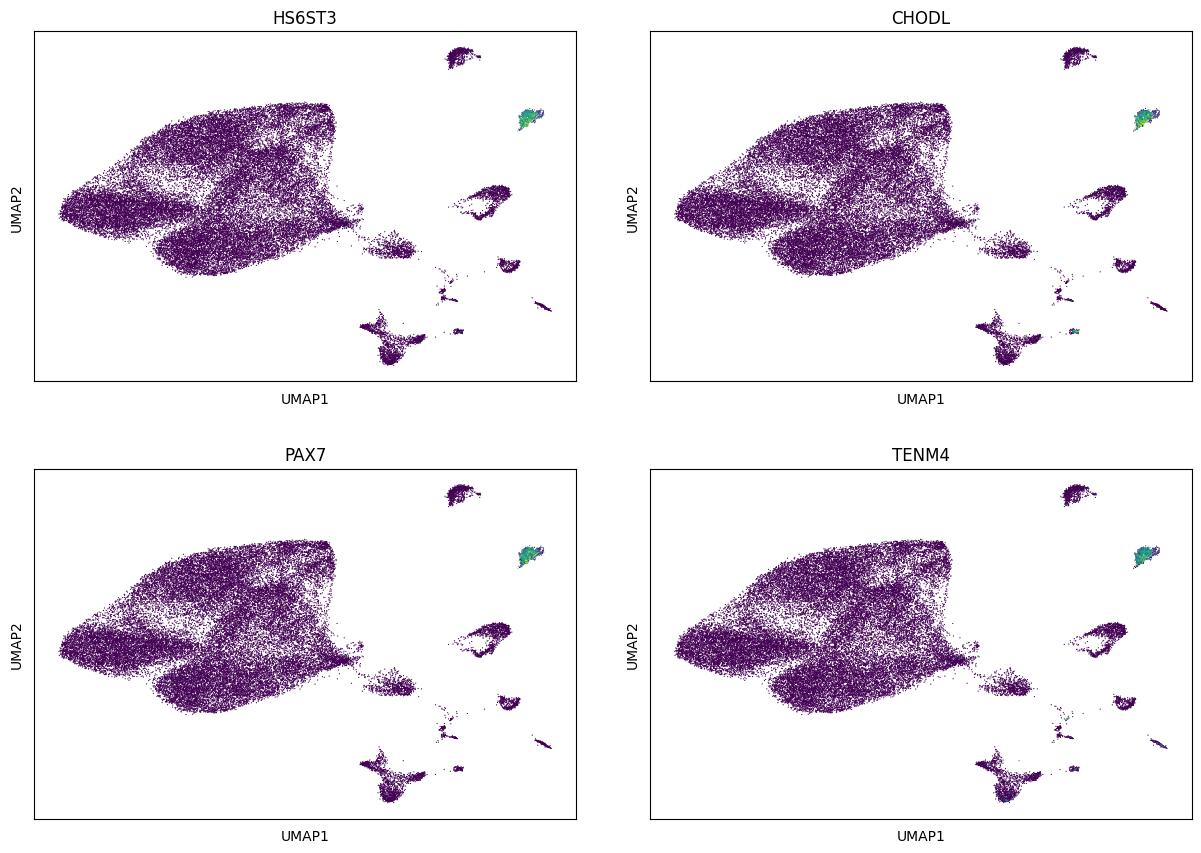

<Figure size 640x480 with 0 Axes>

In [15]:
import matplotlib.pyplot as plt

# specify a save directory for figures
save_folder = '/ocean/projects/cis240075p/asachan/bio_informatics_analysis/TA_muscle_mouse_analysis/figures/'
markers = {
    "Fast IIX": ["MYH1", "KCNN2", "ACSS2", "FHL1"],
    "Fast IIB": ["ACTN3", "SORBS2", "XPR1"],
    "FAPs": ["TNXB", "PLXDC2", "EGFR", "GSN"],
    "Skeleton MuSc": ["HS6ST3", "CHODL", "PAX7", "TENM4"]
}
os.makedirs(f"{save_folder}/marker/", exist_ok=True)
for cell_type, genes in markers.items():
    logging.info(f"Marker gene of {cell_type}")
    sc.pl.umap(adata, color=genes, use_raw=False, ncols=2,colorbar_loc=None,save=False) ## scanpy save sucksss. Use plt.savefig instead
    plt.savefig(f"{save_folder}/marker/umap_marker_genes_{cell_type}.pdf")

#### Get separate GRNs for each sample (for comparison b/w WT and seeing if in-silico perturb data matches ERCC1 perturbation)

In [20]:
adata

AnnData object with n_obs × n_vars = 40106 × 20403
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'log10GenesPerUMI', 'seurat_clusters', 'RNA_snn_res.0.6', 'cell_type', 'condition', 'n_counts_all'
    var: 'highly_variable', 'n_counts', 'mt', 'linc', 'rps', 'rpl'
    uns: 'harmony', 'pca', 'cell_type_colors'
    obsm: 'X_harmony', 'X_pca', 'X_umap'
    varm: 'PCs', 'harmony'
    layers: 'counts'
    obsp: 'nn', 'snn'

In [16]:
#display head of orig.ident obs column
adata.obs['orig.ident'].head()

F7_KO_AAACCCAAGATTCGAA-1    F7_KO
F7_KO_AAACCCACACTCATAG-1    F7_KO
F7_KO_AAACCCACAGCCTTCT-1    F7_KO
F7_KO_AAACCCACAGTATGAA-1    F7_KO
F7_KO_AAACCCACATCATTGG-1    F7_KO
Name: orig.ident, dtype: category
Categories (4, object): ['F7_KO', 'F15_WT', 'M4_KO', 'M11_WT']

In [17]:
# get sample specific anndata objects
adata_F_KO = adata[adata.obs['orig.ident'] == 'F7_KO']
adata_F_WT = adata[adata.obs['orig.ident'] == 'F15_WT']
adata_M_KO = adata[adata.obs['orig.ident'] == 'M4_KO']
adata_M_WT = adata[adata.obs['orig.ident'] == 'M11_WT']

In [18]:
# save sample specific anndata objects
adata_F_KO.write(os.path.join(data_dir, 'F7_KO.h5ad'))
adata_F_WT.write(os.path.join(data_dir, 'F15_WT.h5ad'))
adata_M_KO.write(os.path.join(data_dir, 'M4_KO.h5ad'))
adata_M_WT.write(os.path.join(data_dir, 'M11_WT.h5ad'))